Este notebook será una extensión y modificación del anterior. Por este motivo, el formato podría ser ligeramente similar. El principal cambio que se le hará, es el de modificar el soporte a la hora de instanciar las caritas. Además, se cambiará el número de datos $\{x_i\}_{i=1}^{n}$ con $n=10$ en vez de $n=3$ como en el notebook anterior.

# Imports y configuraciones iniciales

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from quickdraw import QuickDrawDataGroup
import PIL

from bwb.distributions import DistributionDraw, DistributionDrawBuilder

Importamos los datos utilizando el archivo npy que proporciona Google Cloud.

In [2]:
data = np.load(r"..\data\face.npy")
data.shape

(161666, 784)

Hacemos una lista de caritas, fijando un generador con la semilla 42 para tener resultados replicables.

In [3]:
%%time
FLOOR = 30

rng = np.random.default_rng(42)
faces: list[DistributionDraw] = list()
n_faces = len(data)

dist_draw_builder = DistributionDrawBuilder(seed=rng)

for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    arr = np.minimum(arr, (255 - FLOOR) * np.ones_like(arr)).astype("uint8")
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces.append(dd_arr)

CPU times: total: 5.36 s
Wall time: 5.37 s


In [20]:
import ipyplot
import warnings
warnings.filterwarnings("ignore")


random_samples = [face.image for face in faces]

ipyplot.plot_images(random_samples, max_images=48, img_width=75)

Observamos la primera carita

In [4]:
faces[0].image

Observamos un histograma de esta carita, para ver si se tiene el comportamiento es el deseado.

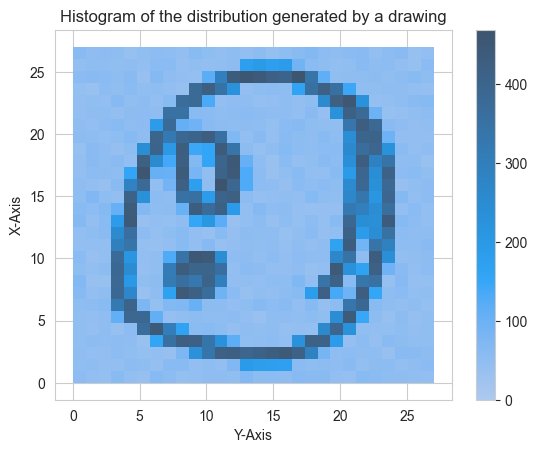

In [5]:
from bwb.utils import plot_histogram_from_points

x = np.array(faces[0].rvs(100_000))
plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

Por lo que parece, sí tiene soporte distinto de 0.

Muestrear con respecto a una carita (la primera para simplificar)

In [6]:
first_face = DistributionDraw.fromarray(255 - data[0, :].reshape(28, 28),
                                        seed=rng)
first_face.image

In [7]:
n = 30
x = first_face.rvs(size=n)
x

[(23, 19),
 (23, 21),
 (12, 25),
 (8, 17),
 (21, 6),
 (19, 4),
 (22, 21),
 (22, 17),
 (8, 23),
 (15, 2),
 (11, 10),
 (23, 17),
 (10, 23),
 (4, 10),
 (12, 1),
 (8, 9),
 (3, 7),
 (23, 12),
 (19, 9),
 (5, 16),
 (10, 10),
 (8, 23),
 (22, 6),
 (20, 7),
 (5, 14),
 (3, 7),
 (22, 7),
 (23, 18),
 (24, 12),
 (5, 17)]

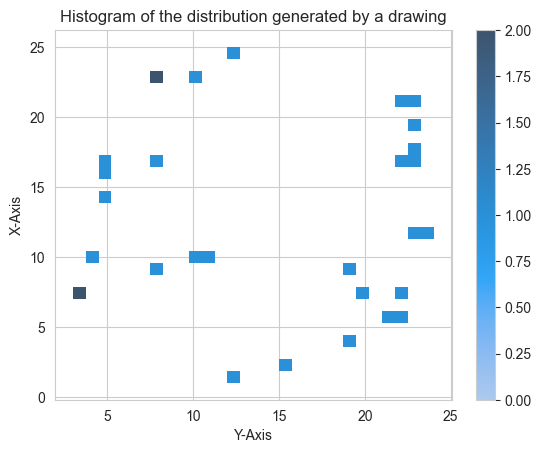

In [8]:
from bwb.utils import plot_histogram_from_points

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

Defino
\begin{equation}
\tilde\Lambda_n(m) = \prod_{i=1}^{n} f_m(x_i)
\end{equation}

A través de la función `likelihood`

In [9]:
def likelihood(mu: DistributionDraw, data: list[tuple[int, int]]):
    evaluations = []
    for i in range(len(data)):
        evaluations.append(mu.matrix[data[i]])
    return np.prod(evaluations)
likelihood(mu=faces[0], data=x)

3.975993413040496e-77

# Metropolis Algorithm

En esta sección se implementa el *Metropolis Algorithm*. Este posee la siguiente matriz $R$:
\begin{equation}
R_{\mu, \nu} = (\text{degr}(\mu))^{-1} = \frac{1}{|\mathcal{M} - 1|}
\end{equation}
donde lo último es por la forma que posee el grafo escogido.

In [10]:
%%time
EPS = 1e-16  # Holgura para el determinador, para evitar dividir por 0

N = 10_000  # 10_000
mu = []

# Paso 1. Empezar con una distribución inicial mu^(0) \in M
current_face = int(rng.choice(n_faces))
mu.append(faces[current_face])  # mu^(0)

# Paso 2.
for i in range(N):
    # Paso a. muestrear u ~ U[0, 1]
    u = rng.uniform(low=0, high=1)

    # Paso b. muestrear mu^star de acuerdo a R partiendo desde mu^(i)
    possible_faces = list(range(n_faces))
    possible_faces.remove(current_face)
    # Escoger una carita
    next_face = int(rng.choice(possible_faces))
    mu_star = faces[next_face]

    # Paso c.
    # Luego calculamos la probabilidad de aceptación
    A_mu_i_mu_star = min(1, (likelihood(mu_star, data=x))
                            / (likelihood(mu[i], data=x) + EPS))

    print("=" * 10)
    print(f"{i = }")
    print(f"{A_mu_i_mu_star = }")
    if u < A_mu_i_mu_star:
        mu.append(mu_star)

        print(f"{current_face = } -> {next_face = }")
        print(f"{u = }")

    else:
        mu.append(mu[i])

    # Moverse a la siguiente carita
    current_face = next_face

i = 0
A_mu_i_mu_star = 1.5872423058253988e-73
i = 1
A_mu_i_mu_star = 1.996414109876818e-74
i = 2
A_mu_i_mu_star = 3.326699691899464e-70
i = 3
A_mu_i_mu_star = 7.405998481459738e-72
i = 4
A_mu_i_mu_star = 1.0734969466228018e-72
i = 5
A_mu_i_mu_star = 1.527283785574722e-76
i = 6
A_mu_i_mu_star = 2.4993014101718723e-71
i = 7
A_mu_i_mu_star = 4.880491433574134e-75
i = 8
A_mu_i_mu_star = 9.819494491792561e-75
i = 9
A_mu_i_mu_star = 1.2243359547202856e-73
i = 10
A_mu_i_mu_star = 2.3705678386973343e-75
i = 11
A_mu_i_mu_star = 1.512142777441489e-67
i = 12
A_mu_i_mu_star = 2.4219005983673267e-72
i = 13
A_mu_i_mu_star = 3.6698743273961245e-76
i = 14
A_mu_i_mu_star = 1.0321173013494422e-74
i = 15
A_mu_i_mu_star = 1.0102700010206725e-73
i = 16
A_mu_i_mu_star = 6.390760942349829e-69
i = 17
A_mu_i_mu_star = 1.1353817844255813e-71
i = 18
A_mu_i_mu_star = 2.3453478160494888e-73
i = 19
A_mu_i_mu_star = 9.24071173664659e-71
i = 20
A_mu_i_mu_star = 3.399961102756925e-72
i = 21
A_mu_i_mu_star = 3.95423988

Empecemos observando las distintas imágenes que generó

In [11]:
# Primera imagen generada
mu[0].image

In [12]:
# Última imagen generada
mu[-1].image

# Gibbs Sampler

Ahora empecemos a generar la otra variación del algoritmo: *Gibbs Sampler*. Después de unos cálculos, este posee la siguiente matriz $R$:
\begin{equation}
R_{\mu, \nu} = \frac{
\tilde \Lambda_n(\nu)
}{
\sum_{\tilde \nu \in \mathcal{M}} \tilde \Lambda_n(\tilde \nu) - \tilde \Lambda_n(\mu)
}
\end{equation}
con la función $\tilde\Lambda_n$ definida como antes.

Notemos que, la gran diferencia con el otro algoritmo es la forma de calcular la matriz $R$. Por este motivo se copiará y pegará el algoritmo anterior, modificando este valor.

In [13]:
%%time
likelihood_cache = np.array([likelihood(nu_tilde, data=x) for nu_tilde in faces])
# Cálculo de la sumatoria, que es un valor genérico para todos
sum_lambdas_n = sum(likelihood_cache)
sum_lambdas_n

CPU times: total: 8.77 s
Wall time: 8.77 s


2.6669099791641125e-76

In [14]:
sum(likelihood_cache > 0)

161666

In [15]:
%%time
EPS = 1e-16  # Holgura para el determinador, para evitar dividir por 0

N = 10_000
mu = []
possible_faces = list(range(n_faces))

# Paso 1. Empezar con una distribución inicial mu^(0) \in M
current_face = int(rng.choice(n_faces))
mu.append(faces[current_face])  # mu^(0)
probabilities = {i: None for i in range(n_faces)}

# Paso 2.
for i in range(N):
    # Paso a. muestrear u ~ U[0, 1]
    u = rng.uniform(low=0, high=1)

    # Paso b. muestrear mu^star de acuerdo a R partiendo desde mu^(i)
    # Calcular las probabilidades
    if probabilities[current_face] is None:
        print(f"Calculando las probabilidades de transición de la carita {i = }")
        probabilities[current_face] = np.array([
            likelihood_cache[face_i]
            / (sum_lambdas_n - likelihood_cache[current_face]) for face_i in possible_faces
        ])
        probabilities[current_face][current_face] = 0.
        probabilities[current_face] /= probabilities[current_face].sum()
        print(f"{sum(probabilities[current_face]) = }")
    # Escoger una carita
    next_face = int(rng.choice(possible_faces, p=probabilities[current_face]))
    mu_star = faces[next_face]

    # Paso c.
    # calculamos la probabilidad de aceptación
    A_mu_i_mu_star = min(1, (sum_lambdas_n - likelihood_cache[current_face])
                         / (sum_lambdas_n - likelihood_cache[next_face])
                         )

    print("=" * 10)
    print(f"{i = }")
    print(f"{A_mu_i_mu_star = }")
    if u < A_mu_i_mu_star:
        mu.append(mu_star)

        print(f"{current_face = } -> {next_face = }")
        print(f"{u = }")

    else:
        mu.append(mu[i])

    # Moverse a la siguiente carita
    current_face = next_face

Calculando las probabilidades de transición de la carita i = 0
sum(probabilities[current_face]) = 0.9999999999999326
i = 0
A_mu_i_mu_star = 1
current_face = 142829 -> next_face = 158455
u = 0.17702362968158658
Calculando las probabilidades de transición de la carita i = 1
sum(probabilities[current_face]) = 0.99999999999994
i = 1
A_mu_i_mu_star = 0.8523850990635878
current_face = 158455 -> next_face = 143104
u = 0.002311542165397751
Calculando las probabilidades de transición de la carita i = 2
sum(probabilities[current_face]) = 0.9999999999999166
i = 2
A_mu_i_mu_star = 0.9933320280135813
current_face = 143104 -> next_face = 18825
u = 0.14104224350390093
Calculando las probabilidades de transición de la carita i = 3
sum(probabilities[current_face]) = 0.9999999999999131
i = 3
A_mu_i_mu_star = 1
current_face = 18825 -> next_face = 143104
u = 0.20958511431212357
i = 4
A_mu_i_mu_star = 1
current_face = 143104 -> next_face = 98586
u = 0.3665332637853864
Calculando las probabilidades de trans

In [16]:
not_none_keys = []
for k, v in probabilities.items():
    if v is not None:
        not_none_keys.append(k)

len(not_none_keys)

545

Empecemos observando las distintas imágenes que generó

In [17]:
# Primera imagen generada
mu[0].image

In [18]:
import ipyplot
import warnings
warnings.filterwarnings("ignore")


random_samples = [faces[k].image for k in not_none_keys]

ipyplot.plot_images(random_samples, max_images=48, img_width=75)

In [19]:
# Última imagen generada
mu[-1].image